In [ ]:
#Install BERT for tensorflow 2
!pip install bert-for-tf2

#Weights for BERT
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip



     |████████████████████████████████| 40kB 2.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.5-cp36-none-any.whl size=30315 sha256=34ecb392223f3e5496c72e8afca2e7d3904f0e5616e3cea2dd5d907defb51a60
  Stored in directory: /root/.cache/pip/wheels/2e/70/a2/be357037dd2cbdcaeb0add1fdf083be6a600ca65ee1f68751c
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=be285e5f90196426453fcc79ea14f64848d2509a485d6ddeeca74fa876615dd4
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=4ab94a9b826e2dd5263b0da1bfa2715224d79445370015ce80a6378b41a3bd16
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


Import the required files

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import string
import re

from keras.models import model_from_json



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Load the data into dataframes

In [ ]:
train = pd.read_csv('train.csv')
submission = pd.read_csv('test.csv')
test = submission
sample_submission = pd.read_csv("sample_submission.csv")

Exploratory Data Analysis

In [ ]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
submission.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
sample_submission.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

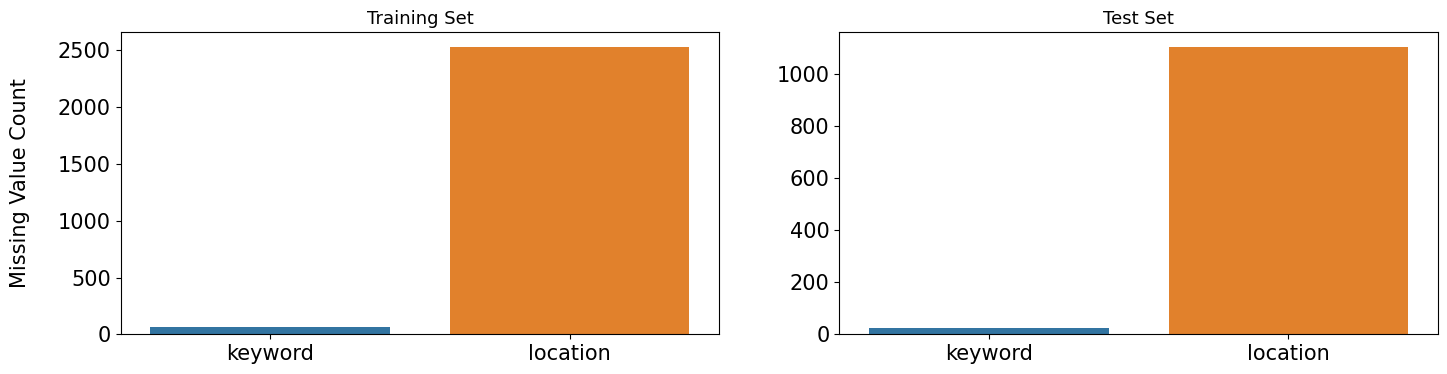

In [ ]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test[missing_cols].isnull().sum().index, y=test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [ ]:
train = train.fillna('None')
ag = train.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag.sort_values('Disaster Probability', ascending=False).head(10)
keyword_list = list(ag[(ag['Count']>2) & (ag['Disaster Probability']>=0.9)].index)
Count = list(ag[(ag['Count']>2) & (ag['Disaster Probability']>=0.9)].Count)
prob = list(ag[(ag['Count']>2) & (ag['Disaster Probability']>=0.9)]["Disaster Probability"])


In [ ]:
ag

,Count,Disaster Probability
keyword,,
ablaze,36,0.361111
accident,35,0.685714
aftershock,34,0.000000
airplane%20accident,35,0.857143
ambulance,38,0.526316
...,...,...
wounded,37,0.702703
wounds,33,0.303030
wreck,37,0.189189


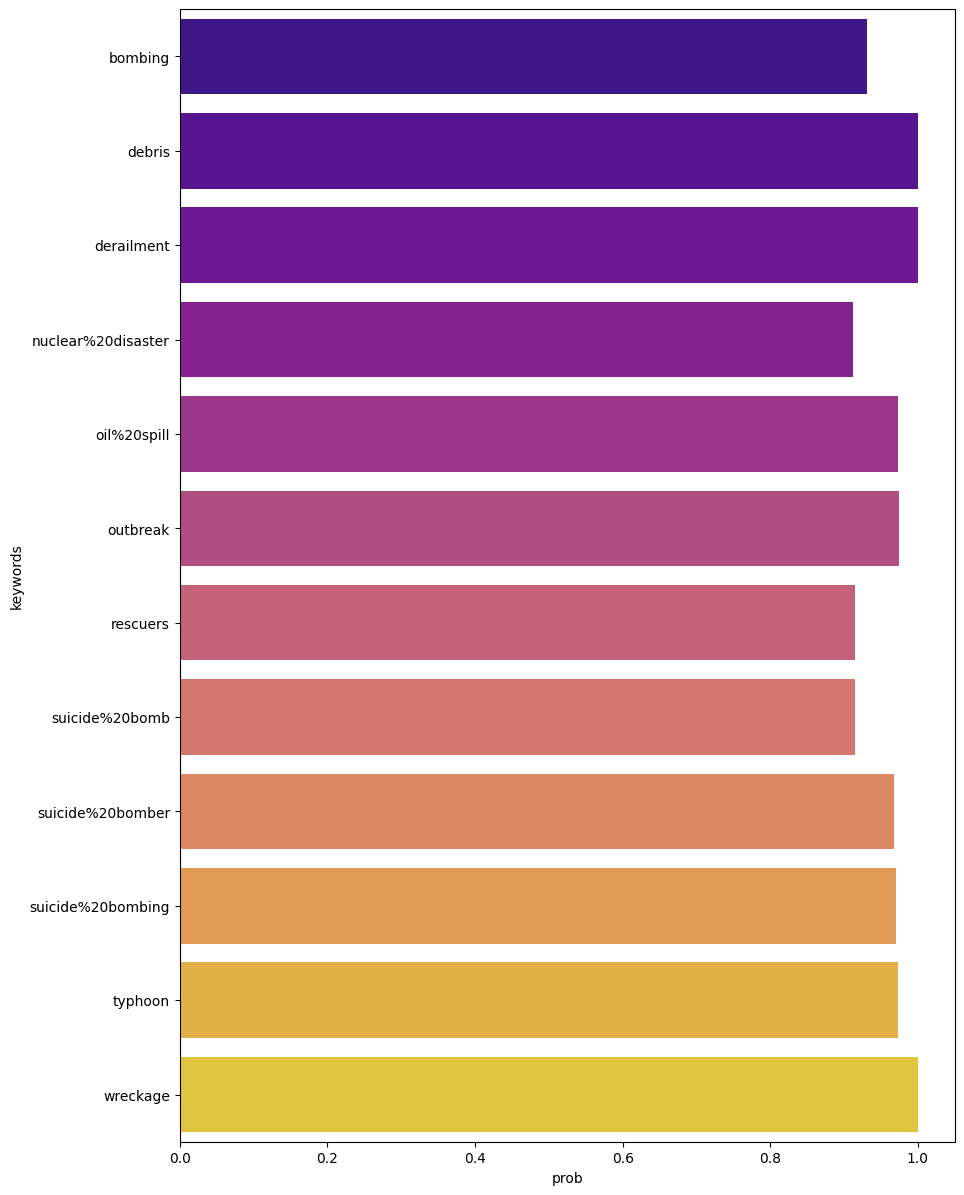

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=1, figsize=(10,15), dpi=100)


df1 = pd.DataFrame(list(zip(keyword_list, Count)), columns =['keywords', 'Count'])
df2 = pd.DataFrame(list(zip(keyword_list, prob)), columns =['keywords', 'prob']) 

plt = sns.barplot(x ='prob', y ='keywords', data = df2, palette ='plasma') 





In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.2)


Feature Engineering

In [ ]:
#Clean your text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

train['text'] = train['text'].apply(lambda x: remove_URL(x))
train['text'] = train['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x: remove_html(x))
train['text'] = train['text'].apply(lambda x: remove_punct(x))

test['text'] = test['text'].apply(lambda x: remove_URL(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_html(x))
test['text'] = test['text'].apply(lambda x: remove_punct(x))



In [ ]:
train.head()

,id,keyword,location,text,target
7560,10809,wrecked,no_location,The twins pitchers ego is now WRECKED,0
1190,1715,bridge%20collapse,Leicester,LeicesterMerc ICYMI Ashes 2015 Australia col...,0
7317,10472,wild%20fires,"West Vancouver, B.C.",Man selling WILD MORELS at Ambleside Farmr Mar...,0
5203,7430,obliterated,Canada,Silverhusky Shtap Before your town is obliter...,0
2131,3059,deaths,AsunciÌ_n-PY / TÌ_bingen-GER,Breast milk is the original superfood but rate...,0


In [ ]:
test.head()

,id,keyword,location,text,target
1239,1786,buildings%20on%20fire,no_location,Smoke detectors not required in all buildings ...,1
3510,5017,eyewitness,Rhode Island,WPRI 12 Eyewitness News Rhode Island set to mo...,0
5800,8279,rioting,no_location,The last time a high profile name was due to b...,1
298,438,apocalypse,Las Vegas,I know where to go when the zombies take over,0
2639,3787,destruction,"ÌÏT: 19.123127,72.825133",Self destruction mode,0


In [ ]:
#Drop the location and keyword columns
train = train[['text','target']]
test = test[['text','target']]

In [ ]:
train.shape

(6090, 2)

In [ ]:
train.isnull().sum()

text      0
target    0
dtype: int64

Build Your Model

In [ ]:
bert_ckpt_dir = '/content/drive/My Drive/DisasterTweet/uncased_L-12_H-768_A-12'
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [ ]:
tokenizer = FullTokenizer(
  vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt")
)

In [ ]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "target"

  def __init__(
    self,
    train,
    test,
    tokenizer: FullTokenizer,
    classes,
    max_seq_len=192
  ):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) =\
     map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(
      self._pad,
      [self.train_x, self.test_x]
    )

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label =\
       row[IntentDetectionData.DATA_COLUMN], \
       row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")

  input_ids = keras.layers.Input(
    shape=(max_seq_len, ),
    dtype='int32',
    name="input_ids"
  )
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(
    units=len(classes),
    activation="softmax"
  )(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)

  return model

In [ ]:
classes = train.target.unique().tolist()

data = IntentDetectionData(
  train,
  test,
  tokenizer,
  classes,
  max_seq_len=128
)

6090it [00:03, 1925.92it/s]
1523it [00:00, 1947.93it/s]


max seq_len 54


In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)


bert shape (None, 54, 768)
Done loading 196 BERT weights from: /content/drive/My Drive/DisasterTweet/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f7a33eaeb38> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 54)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 54, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1538  

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)


In [ ]:
log_dir = "log/intent_detection/" +\
 datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x,
  y=data.train_y,
  validation_data = (data.test_x,data.test_y),
  batch_size=16,
  shuffle=True,
  epochs=15,
  callbacks=[tensorboard_callback]
)


Epoch 1/15
381/381 [==============================] - 287s 752ms/step - loss: 0.4762 - acc: 0.8320 - val_loss: 0.4742 - val_acc: 0.8345
Epoch 2/15
381/381 [==============================] - 285s 749ms/step - loss: 0.4562 - acc: 0.8529 - val_loss: 0.4791 - val_acc: 0.8326
Epoch 3/15
381/381 [==============================] - 285s 748ms/step - loss: 0.4444 - acc: 0.8657 - val_loss: 0.4790 - val_acc: 0.8306
Epoch 4/15
381/381 [==============================] - 285s 747ms/step - loss: 0.4311 - acc: 0.8793 - val_loss: 0.4795 - val_acc: 0.8313
Epoch 5/15
381/381 [==============================] - 285s 748ms/step - loss: 0.4226 - acc: 0.8900 - val_loss: 0.4821 - val_acc: 0.8273
Epoch 6/15
381/381 [==============================] - 285s 749ms/step - loss: 0.4149 - acc: 0.8977 - val_loss: 0.4779 - val_acc: 0.8326
Epoch 7/15
381/381 [==============================] - 285s 748ms/step - loss: 0.4110 - acc: 0.9010 - val_loss: 0.4815 - val_acc: 0.8273
Epoch 8/15
381/381 [============================

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

48/48 [==============================] - 16s 327ms/step - loss: 0.4953 - acc: 0.8168
train acc 0.9256157875061035
test acc 0.8168089389801025


Results

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  
actual = list(test['target']) 

X_val = data.test_x

val_predictions = model.predict(X_val, verbose=0)

print("1")
prediction_final = []
for i in list(val_predictions):
  if(i[0]>=i[1]):
    prediction_final.append(0)
  else:
    prediction_final.append(1)
val_predictions = np.array(prediction_final) 

predicted = list(val_predictions)

results = confusion_matrix(actual, predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(actual, predicted))
print('Report : ')
print(classification_report(actual, predicted))

1
Confusion Matrix :
[[683 159]
 [120 561]]
Accuracy Score : 0.8168089297439265
Report : 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       842
           1       0.78      0.82      0.80       681

    accuracy                           0.82      1523
   macro avg       0.81      0.82      0.82      1523
weighted avg       0.82      0.82      0.82      1523



Save the model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_10epoch_f.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_10epoch_f.h5")
print("Saved model to disk")

In [ ]:
submission['text'] = submission['text'].apply(lambda x: remove_URL(x))
submission['text'] = submission['text'].apply(lambda x: remove_emoji(x))
submission['text'] = submission['text'].apply(lambda x: remove_html(x))
submission['text'] = submission['text'].apply(lambda x: remove_punct(x))

In [ ]:
submission.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
sentences = submission.text.to_list()

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(
  lambda tids: tids +[0]*(data.max_seq_len-len(tids)),
  pred_token_ids
)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

texts = []
predict = []

for text, label in zip(sentences, predictions):
  #print("text:", text, "\nintent:", classes[label])
  texts.append(text)
  predict.append(classes[label])

  #print()

In [ ]:
data = {'text':texts, 'target':predict} 
  
df_submissions = pd.DataFrame(data) 

In [ ]:
df_submissions.head()

,text,target
0,Just happened a terrible car crash,1
1,Heard about earthquake is different cities sta...,1
2,there is a forest fire at spot pond geese are ...,1
3,Apocalypse lighting Spokane wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


In [ ]:
submission['target'] = df_submissions['target']

In [ ]:
submission.head(100)

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,Heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
95,323,annihilated,NaN,If your nature appropriates it love will burn ...,0
96,324,annihilated,NaN,NinaHoag if you shred my Psych work our frien...,0
97,325,annihilated,upstate NY,thehill this is 1 example of y the Conservativ...,0
98,326,annihilated,NaN,Aug 3 1915ÛÓKAISERJAEGERS WIPED OUT Francis J...,1


In [ ]:
submission.to_csv("final_results.csv")